# RNN

In [3]:
VOCAB_SIZE = 300  # 사용할 단어 수
SEQ_LEN = 100     # 시퀀스 하나의 최대 길이

### 데이터 준비

In [4]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
import torch

train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input]

train_target = torch.tensor(train_target, dtype=torch.long)
test_target = torch.tensor(test_target, dtype=torch.long)

print(len(train_input), len(test_input))
print(train_target.shape, test_target.shape)

25000 25000
torch.Size([25000]) torch.Size([25000])


In [6]:
train_input, test_input = train_input[:10000], test_input[:5000]
train_target, test_target = train_target[:10000], test_target[:5000]

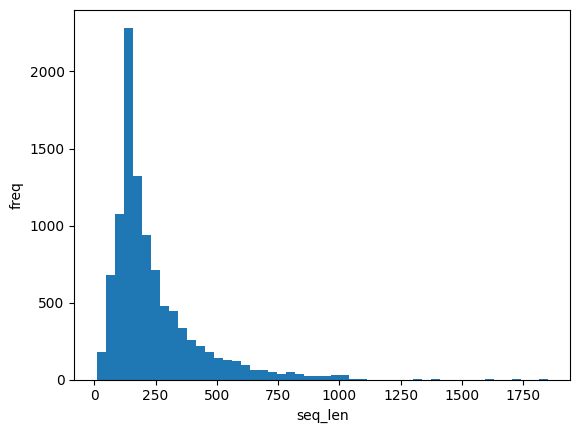

In [7]:
# 입력 데이터 길이 체크
import matplotlib.pyplot as plt
import numpy as np

train_len = [len(seq) for seq in train_input]

plt.hist(train_len, bins=50)
plt.xlabel('seq_len')
plt.ylabel('freq')
plt.show()

In [8]:
# padding 처리
import torch.nn.functional as F

def pad_sequences(sequences, maxlen, padding_value=0):
  padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
  return torch.stack(padded_sequences)


train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

train_seq.shape, test_seq.shape

(torch.Size([10000, 100]), torch.Size([5000, 100]))

In [9]:
# one-hot encoding
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 100, 300]), torch.Size([5000, 100, 300]))

### 모델 준비 및 학습

In [10]:
import torch.nn as nn

class SentimentRNN(nn.Module):
  def __init__(self, seq_len, vocab_size, hidden_dim, output_dim):
    super(SentimentRNN, self).__init__()
    self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    _, hidden = self.rnn(x)
    out = self.fc(hidden.squeeze(0))
    return self.sigmoid(out)


In [11]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

model = SentimentRNN(seq_len=SEQ_LEN, vocab_size=VOCAB_SIZE, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)
print(model)

SentimentRNN(
  (rnn): RNN(300, 8, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
total_params = 0
print(f"{'Layer':<20} {'Shape':<30} {'Params'}")
print("=" * 60)

for name, param in model.named_parameters():
  if param.requires_grad:
    param_count = param.numel()
    total_params += param_count
    print(f'{name:<20} {str(list(param.shape)):<30} {param_count}')

print("=" * 60)
print(f'Total Trainable Parameters: {total_params}')

Layer                Shape                          Params
rnn.weight_ih_l0     [8, 300]                       2400
rnn.weight_hh_l0     [8, 8]                         64
rnn.bias_ih_l0       [8]                            8
rnn.bias_hh_l0       [8]                            8
fc.weight            [1, 8]                         8
fc.bias              [1]                            1
Total Trainable Parameters: 2489


Epoch 1/100 | Train Loss: 0.5824, Train Acc: 0.6871, Val Loss: 0.5833, Val Acc: 0.6880
Epoch 2/100 | Train Loss: 0.5797, Train Acc: 0.6914, Val Loss: 0.5834, Val Acc: 0.6850
Epoch 3/100 | Train Loss: 0.5793, Train Acc: 0.6941, Val Loss: 0.5828, Val Acc: 0.6855
Epoch 4/100 | Train Loss: 0.5725, Train Acc: 0.6945, Val Loss: 0.5842, Val Acc: 0.6865
Epoch 5/100 | Train Loss: 0.5709, Train Acc: 0.6993, Val Loss: 0.5835, Val Acc: 0.6875
Epoch 6/100 | Train Loss: 0.5779, Train Acc: 0.6949, Val Loss: 0.6009, Val Acc: 0.6765
Epoch 7/100 | Train Loss: 0.5752, Train Acc: 0.6893, Val Loss: 0.5863, Val Acc: 0.6835
Epoch 8/100 | Train Loss: 0.5682, Train Acc: 0.6943, Val Loss: 0.5865, Val Acc: 0.6815
Epoch 9/100 | Train Loss: 0.5762, Train Acc: 0.6924, Val Loss: 0.6012, Val Acc: 0.6740
Epoch 10/100 | Train Loss: 0.5787, Train Acc: 0.6874, Val Loss: 0.5956, Val Acc: 0.6775
Early stopping!!!


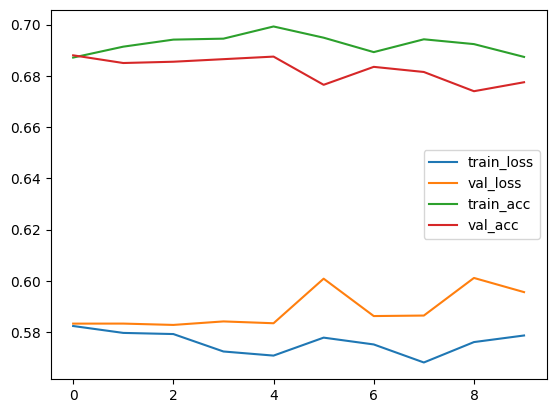

In [21]:
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

# 배치 사이즈 설정 + 학습/검증셋 크기 설정
BATCH_SIZE = 65
train_size = int(len(train_onehot) * 0.8)
val_size = len(train_onehot) - train_size

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

# 학습/검증셋 분할 + 미니배치 사용하도록 DataLoader 생성
train_dataset, val_dataset = random_split(TensorDataset(train_onehot, train_target), [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# epoch, 손실함수, 최적화함수 정의
epochs = 100
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 시각화를 위한 손실값, 정확도 저장용
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# 조기종료 관련 변수 초기화
early_stopping_patience = 7
best_val_loss = float('inf')
early_stop_counter = 0

# 학습 과정
for epoch in range(epochs):
  # train mode
  model.train()
  total_loss, correct, total = 0, 0, 0

  for inputs, targets in train_loader:
    optimizer.zero_grad()               # 가중치 초기화
    outputs = model(inputs).squeeze()   # 순전파

    loss = criterion(outputs, targets)  # 손실 계산

    loss.backward()                     # 역전파
    optimizer.step()                    # 가중치 업데이트
    total_loss += loss.item()

    pred = (outputs > 0.5).float()
    correct += (pred == targets).sum().item()
    total += targets.size(0)

  train_loss = total_loss / len(train_loader)
  train_acc = correct / total
  train_losses.append(train_loss)
  train_accs.append(train_acc)

  # validation mode
  model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in val_loader:
      val_outputs = model(val_inputs).squeeze()   # 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  val_loss = val_loss / len(val_loader)
  val_acc = val_correct / val_total
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

  # 조기종료 처리
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    early_stop_counter = 0
  else:
    early_stop_counter += 1
    if early_stop_counter >= early_stopping_patience:
      print("Early stopping!!!")
      break

# 시각화
train_history_df = pd.DataFrame({
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accs,
    "val_acc": val_accs
})
train_history_df.plot()
plt.show()

In [22]:
def evaluate_model(model, test_loader, criterion):
  model.eval()
  val_loss, val_correct, val_total = 0, 0, 0

  with torch.no_grad():
    for val_inputs, val_targets in test_loader:
      val_outputs = model(val_inputs).squeeze()   # 순전파
      loss = criterion(val_outputs, val_targets)  # 손실 계산
      val_loss += loss.item()

      val_pred = (val_outputs > 0.5).float()
      val_correct += (val_pred == val_targets).sum().item()
      val_total += val_targets.size(0)

  test_loss = val_loss / len(test_loader)
  test_acc = val_correct / val_total
  return test_loss, test_acc

In [23]:
test_dataset = TensorDataset(test_onehot, test_target)
test_loader = DataLoader(test_dataset, batch_size=65)

loss, accuracy = evaluate_model(model, test_loader, criterion)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Test Loss: 0.8123, Test Accuracy: 0.5238
